Run this cell to make the runs deterministic: (This guarantees all algorithms find the solution.)

In [1]:
import random
random.seed(101)

### Introduction

![title](images/prisontext.png)


In [2]:
from IPython.display import clear_output
import runners, crawler, scrambler
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

#### Plausibility Function

![title](images/plausibility.png)

First, I will define the Plausibility function f(x, s, g) where x is the cipher, s is the scrambled string, and g is conditional bigram probability distribution.

In [3]:
def f(x, s, g):
    y = 0
    for i in range(0, len(s) - 1):
        v = g[x[s[i]]][x[s[i + 1]]]
        if v == 0:
            v = 1 / 50000000
        y += np.log(v)
    return y

I'm going to run the simulation with sample text that was used in the paper. I'm using a sanitize function to handle puctuation, random double spaces, and other formatting anomalies.

In [4]:
o = crawler.sanitize('ENTER HAMLET. HAMLET. To be, or not to be, that is the'
                     ' question: Whether ’tis nobler in the mind to suffer T'
                     'he slings and arrows of outrageous fortune')
print(o)

ENTER HAMLET HAMLET TO BE OR NOT TO BE THAT IS THE QUESTION WHETHER TIS NOBLER IN THE MIND TO SUFFER THE SLINGS AND ARROWS OF OUTRAGEOUS FORTUNE


I want to see a visualization of the conditional bigram frequencies, so I'll plot it on a heatmap.

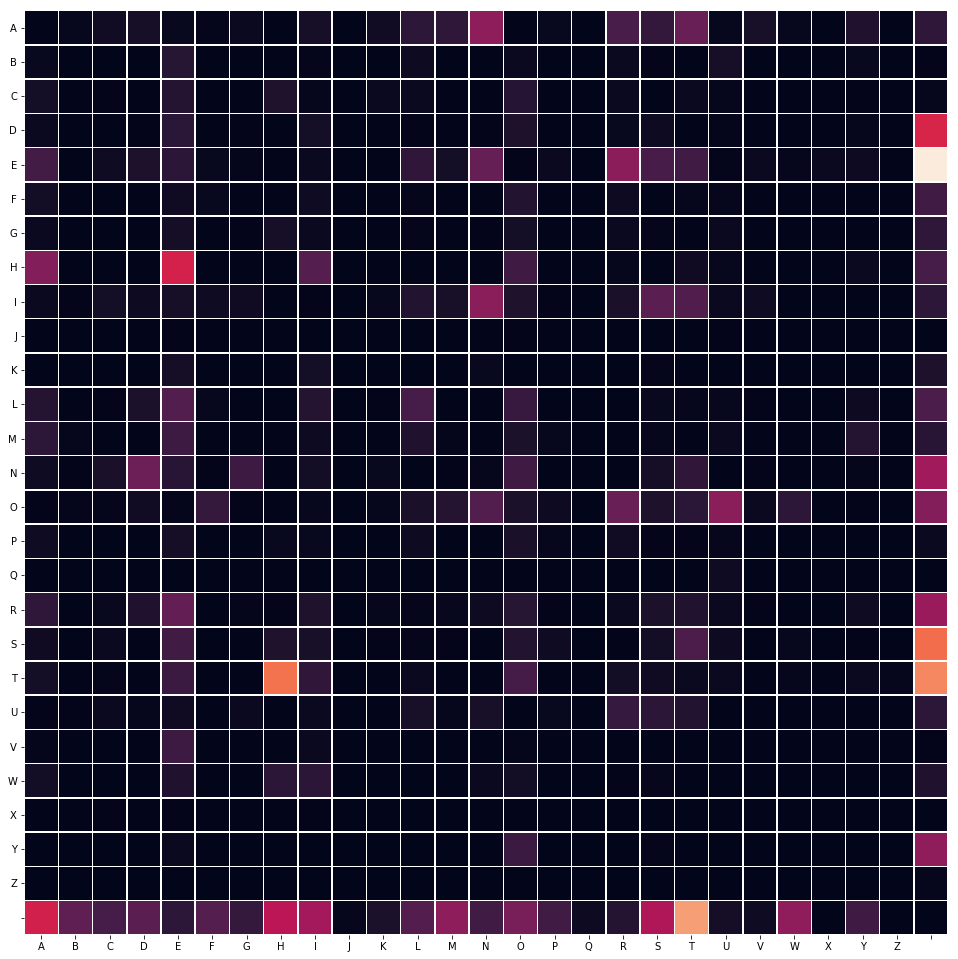

In [5]:
plt.rcParams['figure.figsize'] = [17, 17]
h = crawler.cbfd_from_book('ProjectGutenberg/Hamlet.txt')
sns.heatmap(h, linewidths=.5, square=True, cbar=False, xticklabels=crawler.alphabet, yticklabels=crawler.alphabet)
plt.yticks(rotation=0)
plt.show()

Now I will create the variables needed to run the algorithm. We need a conditional bigram probability distribution g, a scrabled string s, and an initial guess at the cipher x.

In [6]:
g = crawler.cbpd_from_book('ProjectGutenberg/Hamlet.txt')
s = scrambler.scramble(o)
x = dict(zip(crawler.alphabet, crawler.alphabet))
x_ = dict(x)

I want to see what the scrambled cipher looks like when applied to the text

In [7]:
print(scrambler.unscramble_with_cipher(x, s))

O NOCAZSFTONAZSFTONANVAGOAVCA VNANVAGOANZSNAHMANZOADUOMNHV AYZONZOCANHMA VGTOCAH ANZOAFH LANVAMUBBOCANZOAMTH QMAS LASCCVYMAVBAVUNCSQOVUMABVCNU O


I define some variables for controlling the algorithms and output to Jupyter Notebook.

In [8]:
max_iterations = 100000
p_interval = 100
hc_p_interval = 1
hc_max_iterations = 200
hc_rrate = 50

In [9]:
def output_graph(plotx, ploty):
    plt.rcParams['figure.figsize'] = [12, 9]
    plt.title('Iterations vs Plausibility')
    plt.xlabel('Iterations')
    plt.ylabel('-log(Plausibility)')
    plt.plot(plotx, ploty, 'b', label='Plausibility')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

# Hill Climbing

In [10]:
x = dict(x_)
iteration = 1
plotx = []
ploty = []
while iteration < hc_max_iterations and scrambler.unscramble_with_cipher(x, s) != o:
    x = runners.hill_climbing(f, x, s, g)
    plotx.append(iteration)
    ploty.append(-f(x, s, g))
    if iteration % hc_p_interval == 0:
        clear_output(wait=True)
        print('%d %s' % (iteration, scrambler.unscramble_with_cipher(x, s)))
    iteration += 1
clear_output(wait=True)
print('%d %s' % (iteration, scrambler.unscramble_with_cipher(x, s)))

30 ENTER HAMLET HAMLET TO BE OR NOT TO BE THAT IS THE QUESTION WHETHER TIS NOBLER IN THE MIND TO SUFFER THE SLINGS AND ARROWS OF OUTRAGEOUS FORTUNE


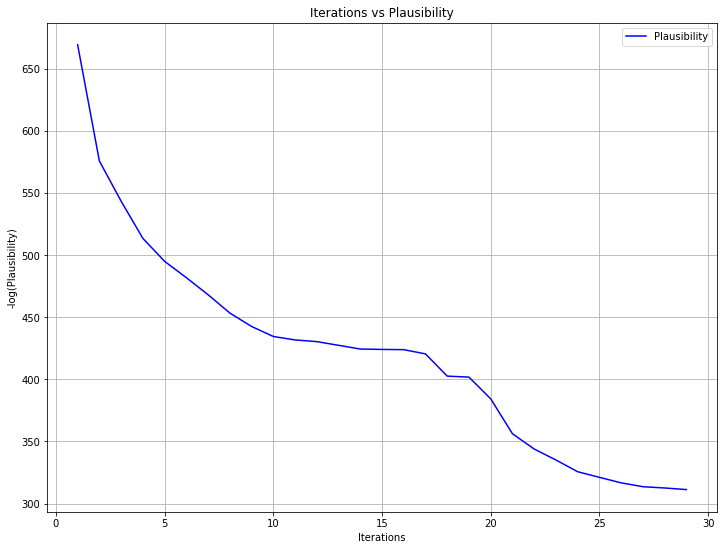

In [11]:
output_graph(plotx, ploty)

# Hill Climbing with Random Restarts

In [12]:
x = dict(x_)
iteration = 1
plotx = []
ploty = []
while scrambler.unscramble_with_cipher(x, s) != o:
    if iteration % hc_p_interval == 0:
        clear_output(wait=True)
        print('%d %s' % (iteration, scrambler.unscramble_with_cipher(x, s)))
    x = runners.hill_climbing(f, x, s, g)
    plotx.append(iteration)
    ploty.append(-f(x, s, g))
    iteration += 1
    if iteration > hc_rrate:
        iteration = 1
        plotx = []
        ploty = []
        x = runners.swap(runners.swap(dict(x_)))
clear_output(wait=True)
print('%d %s' % (iteration, scrambler.unscramble_with_cipher(x, s)))

30 ENTER HAMLET HAMLET TO BE OR NOT TO BE THAT IS THE QUESTION WHETHER TIS NOBLER IN THE MIND TO SUFFER THE SLINGS AND ARROWS OF OUTRAGEOUS FORTUNE


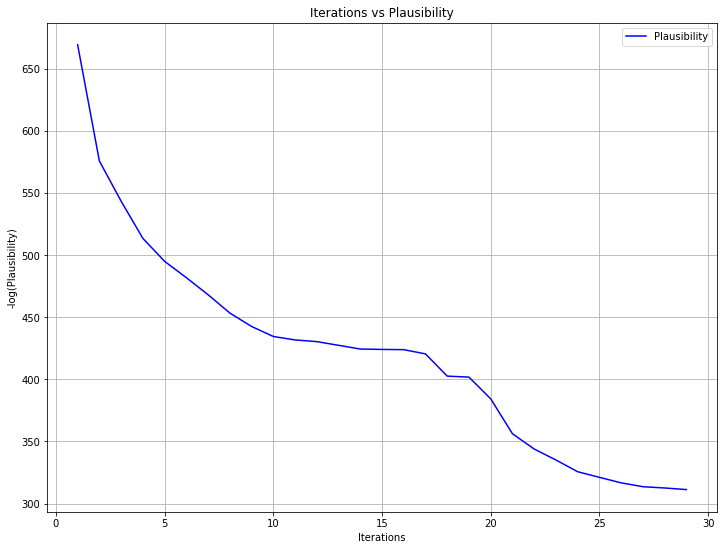

In [13]:
output_graph(plotx, ploty)

# Metropolis Algorithm

In [14]:
x = dict(x_)
iteration = 1
plotx = []
ploty = []
while iteration < max_iterations and scrambler.unscramble_with_cipher(x, s) != o:
    if iteration % p_interval == 0:
        clear_output(wait=True)
        print('%d %s' % (iteration, scrambler.unscramble_with_cipher(x, s)))
    x = runners.metropolis(f, x, s, g)
    plotx.append(iteration)
    ploty.append(-f(x, s, g))
    iteration += 1
clear_output(wait=True)
print('%d %s' % (iteration, scrambler.unscramble_with_cipher(x, s)))

13527 ENTER HAMLET HAMLET TO BE OR NOT TO BE THAT IS THE QUESTION WHETHER TIS NOBLER IN THE MIND TO SUFFER THE SLINGS AND ARROWS OF OUTRAGEOUS FORTUNE


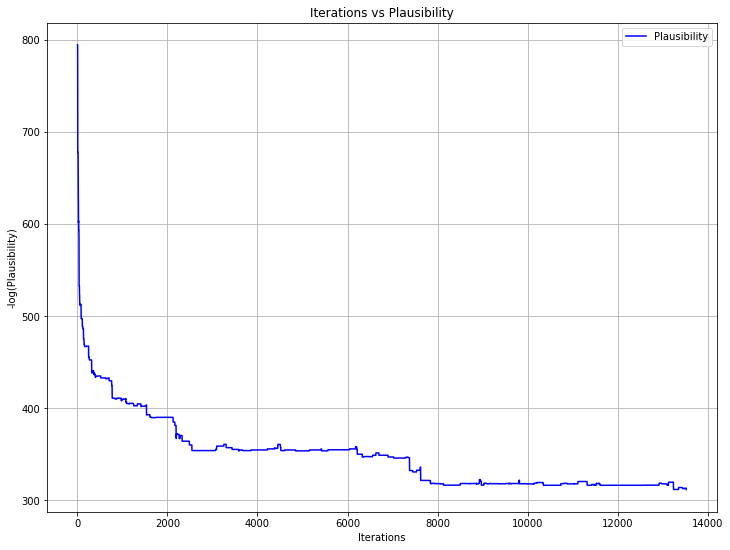

In [15]:
output_graph(plotx, ploty)

# Metropolis-Hastings Algorithm

In [16]:
x = dict(x_)
iteration = 1
plotx = []
ploty = []
while iteration < max_iterations and scrambler.unscramble_with_cipher(x, s) != o:
    if iteration % p_interval == 0:
        clear_output(wait=True)
        print('%d %s' % (iteration, scrambler.unscramble_with_cipher(x, s)))
    x = runners.metropolis_hastings(f, x, s, g)
    plotx.append(iteration)
    ploty.append(-f(x, s, g))
    iteration += 1
clear_output(wait=True)
print('%d %s' % (iteration, scrambler.unscramble_with_cipher(x, s)))

23647 ENTER HAMLET HAMLET TO BE OR NOT TO BE THAT IS THE QUESTION WHETHER TIS NOBLER IN THE MIND TO SUFFER THE SLINGS AND ARROWS OF OUTRAGEOUS FORTUNE


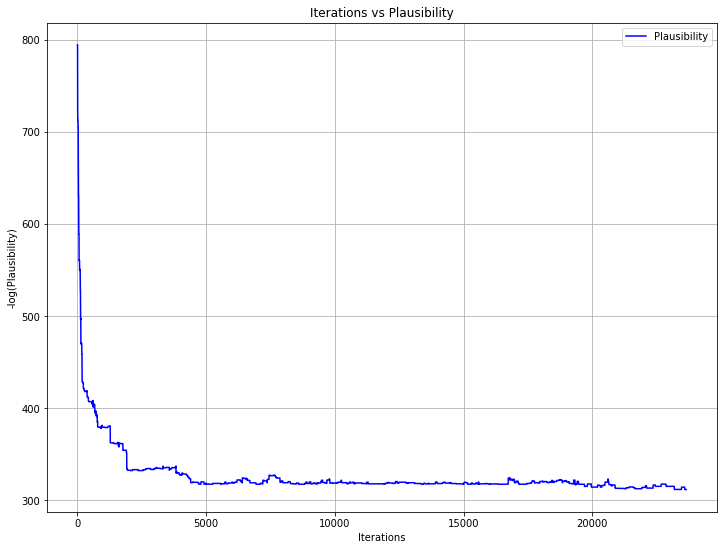

In [17]:
output_graph(plotx, ploty)

# Simulated-Annealing Algorithm

In [18]:
x = dict(x_)
iteration = 1
plotx = []
ploty = []
runners.reset_temp()
while iteration < max_iterations and scrambler.unscramble_with_cipher(x, s) != o:
    if iteration % p_interval == 0:
        clear_output(wait=True)
        print('%d %s' % (iteration, scrambler.unscramble_with_cipher(x, s)))
    x = runners.simulated_annealing(f, x, s, g)
    plotx.append(iteration)
    ploty.append(-f(x, s, g))
    iteration += 1
clear_output(wait=True)
print('%d %s' % (iteration, scrambler.unscramble_with_cipher(x, s)))

17918 ENTER HAMLET HAMLET TO BE OR NOT TO BE THAT IS THE QUESTION WHETHER TIS NOBLER IN THE MIND TO SUFFER THE SLINGS AND ARROWS OF OUTRAGEOUS FORTUNE


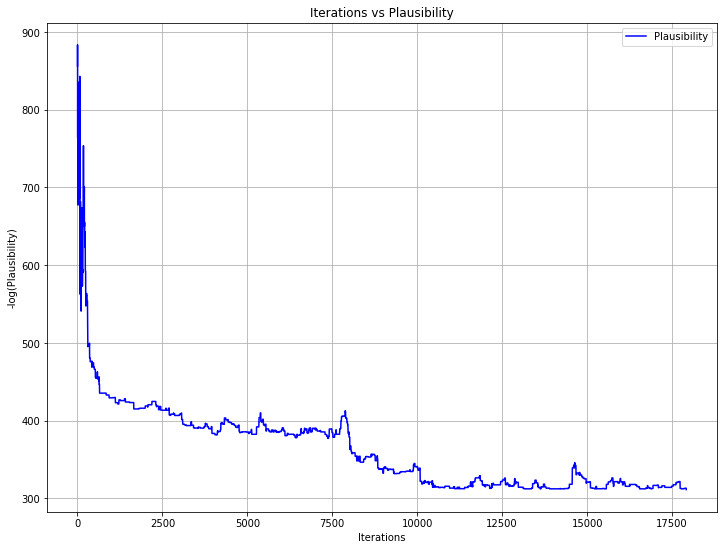

In [19]:
output_graph(plotx, ploty)

### Conclusion

Stay away from prisons so you don't have to solve substitution ciphers.